In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.io as scio
from scipy.optimize import root
from matplotlib.font_manager import FontProperties

rural = np.arange(0, 60, 2)
urban = np.arange(1, 60, 2)
east = np.r_[0, 1, 2, 3, 4, 5, 16, 17, 18, 19, 20, 21, 24, 25, 28, 29, 36, 37, 40, 41]
middle = np.r_[6, 7, 22, 23, 26, 27, 30, 31, 32, 33, 34, 35]
west = np.r_[8, 9, 10, 11, 12, 13, 14, 15, 38, 39, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
high_flow_in = [0, 1, 2, 3, 8, 10, 12, 18, 20] # 前30%
low_flow_in = [4, 5, 6, 7, 9, 11, 13, 14, 15, 16, 17, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29] # 前70%

font_path = r'C:\Windows\Fonts\simsun.ttc'
chinese_font = FontProperties(fname=r'C:\Windows\Fonts\simsun.ttc')
english_font = FontProperties(fname=r'C:\Windows\Fonts\times.ttf')
pd.options.display.float_format = '{:.3f}'.format

# 定义计算基尼系数的函数
def gini_index(array):
    cum_wealths = np.cumsum(sorted(np.append(array, 0)))
    sum_wealths = cum_wealths[-1]
    xarray = np.array(range(0, len(cum_wealths))) / float(len(cum_wealths)-1)
    yarray = cum_wealths / sum_wealths
    B = np.trapz(yarray, x=xarray)
    A = 0.5 - B
    return A / (A + B)

# 定义计算泰尔指数的函数
def theil_index(array):
    mean_income = np.mean(array)
    income_ratio = array / mean_income
    log_income_ratio = np.log(income_ratio, where=(income_ratio!=0))
    contribution = income_ratio * log_income_ratio
    return np.mean(contribution)

In [2]:
# 读取基准情形的变量和参数
equilibrium2010 = np.load('./data/equilibrium2010.npz')
R = equilibrium2010['R']
X = equilibrium2010['X']
m = equilibrium2010['m']
pi = equilibrium2010['pi']
L = equilibrium2010['L']
L_bar = equilibrium2010['L_bar']
K = equilibrium2010['K']
w = equilibrium2010['w']
P = equilibrium2010['P']
W = equilibrium2010['W']

parameter = np.load('./data/Parameter.npz')
kappa = parameter['kappa']
theta = parameter['theta']
beta = parameter['beta']
psi_ag = parameter['psi_ag']
psi_na = parameter['psi_na']
alpha_ag = parameter['alpha_ag']
alpha_na = parameter['alpha_na']
sigma_ag = parameter['sigma_ag']
sigma_na = parameter['sigma_na']
eta_ag_ag = parameter['eta_ag_ag']
eta_ag_na = parameter['eta_ag_na']
eta_na_ag = parameter['eta_na_ag']
eta_na_na = parameter['eta_na_na']
phiu = parameter['phiu']
phip = parameter['phip']
chi = parameter['chi']
eta = parameter['eta']
delta = parameter['delta']
xi_ag = parameter['xi_ag']
xi_na = parameter['xi_na']
t = parameter['t']

In [3]:
# 导入外生变量的反事实变化

## 土地供给
K1017 = np.array(pd.read_excel('./data/raw_and_build/城镇村及工矿用地面积.xlsx').iloc[:, 3:])
K1017 = np.delete(K1017, 25, axis=0) # 删除西藏
dK1117 = K1017[:, 1:] / K1017[:, 0].reshape([30, 1])
dK1117 = K1017[:, 1:] / K1017[:, 0].reshape([30, 1])

## 其他外生变量
dKh = np.concatenate([np.ones([30, 1]), dK1117[:, -1].reshape([30, 1])], axis=1).reshape([60, 1])
dKp = np.concatenate([np.ones([30, 1]), dK1117[:, -1].reshape([30, 1])], axis=1).reshape([60, 1])
dT = np.ones([60, 1])
dtau = np.ones([60, 60])
dmu = np.ones([60, 60])

In [4]:
dKh[high_flow_in].mean()
dW_country_both = 6.4031
dV_country_both = 3.8140
dincgini_country_both = -9.4432
dK1117[:, -1][high_flow_in].mean(), (1 + dW_country_both / 100) ** (1/3) * (1 + dV_country_both / 100) ** (1/3) * (1 + dincgini_country_both / 100) ** (-1/3)

(1.0887330974809624, 1.0684717552015424)

In [5]:
# 求解未发生土地改革时的反事实均衡

def SolveCounter_wo_reform(XX):
    dw = XX[:60].reshape([60, 1])
    dL = XX[60:120].reshape([60, 1])
    dp = XX[120:].reshape([60, 1])

    ## (a)价格指数的变化
    dpdp_wp_c = np.repeat((dp.reshape([30, 2]) ** np.array([psi_ag * beta, psi_na * beta]).reshape([1, 2])).prod(axis=1).reshape([30, 1]), 2, axis=1).reshape([60, 1])
    drh = dw * dL / dKh
    dP =  dpdp_wp_c *  (drh ** (1 - beta))

    ## (b)公共支出的变化
    dG = dw * dL / dP

    ## (c)单位投入束成本的相对变化
    dw_wp = (dw.reshape([30, 2]) ** np.array([alpha_ag, alpha_na]).reshape([1, 2])).reshape([60, 1])
    drp = dw * dL / dKp
    drp_wp = (drp.reshape([30, 2]) ** np.array([sigma_ag, sigma_na]).reshape([1, 2])).reshape([60, 1])
    dpdp_wp_p_ag = (dp.reshape([30, 2]) ** np.array([eta_ag_ag, eta_na_ag]).reshape([1, 2])).prod(axis=1).reshape([30, 1])
    dpdp_wp_p_na = (dp.reshape([30, 2]) ** np.array([eta_ag_na, eta_na_na]).reshape([1, 2])).prod(axis=1).reshape([30, 1])
    dpdp_wp_p = np.concatenate([dpdp_wp_p_ag, dpdp_wp_p_na], axis=1).reshape([60, 1])
    dc = dw_wp * drp_wp * dpdp_wp_p

    ## (d)贸易份额的相对变化
    dpi_num = dT * ((dtau * dc) ** (-theta)) * (dG ** (phip * theta)) * (dL ** (theta * delta)) # 分子(考虑生产函数中存在规模经济效应)
    dpi_den = (dpi_num * pi).sum(axis=0).reshape([60, 1]) # 分母
    dpi = (dpi_num.T / dpi_den).T
    pi_prime = pi * dpi # 反事实情形下的贸易份额

    ## (e)最终品价格的相对变化
    dp1 = dpi_den ** (-1 / theta)

    ## (f)收入倍率保持不变，表明未发生土地改革
    wL = (R.reshape([30, 2]) * np.array([alpha_ag, alpha_na]).reshape([1, 2])).reshape([60, 1]) # 计算总工资收入
    ddelta = np.ones([60, 60]) # ddelta和delta_prime的非主对角线元素是一样的
    
    ## (g)流动份额的相对变化
    dg = dG / (dL ** chi) # 人均公共支出的相对变化
    dW = dw / dP # 实际工资的相对变化
    dm_num = (ddelta * (dmu ** (-1)) * (dg ** phiu) * dW) ** kappa # 分子
    dm_den = (dm_num * m).sum(axis=0).reshape([60, 1]) # 分母
    dm = (dm_num.T / dm_den).T
    m_prime = m * dm

    ## (h)常住人口数的相对变化
    dL1 = (m_prime @ L_bar) / L

    ## (i)计算反事实下的总产出与总支出
    R_prime = R * dw * dL
    wL_prime = wL * dw * dL
    X_prime = np.linalg.inv(pi_prime) @ R_prime ## 根据总产出R_prime计算出的总支出X_prime
    vL_prime = (wL_prime.reshape([30, 2]) * np.array([(alpha_ag + sigma_ag) / (beta + t - beta * t) / alpha_ag, 1]).reshape([1, 2])).reshape([60, 1])
    PG_prime = (wL_prime.reshape([30, 2]) * np.array([t * (alpha_ag + sigma_ag) / (beta + t - beta * t) / alpha_ag, 1 - beta + sigma_na / alpha_na + beta * t]).reshape([1, 2])).reshape([60, 1])
    A_prime = (beta * (1 - t) * np.repeat(vL_prime.reshape([30, 2]).sum(axis=1).reshape([30, 1]), 2, axis=1) * np.array([psi_ag, psi_na]).reshape([1, 2])).reshape([60, 1])
    C_prime = (np.repeat(PG_prime.reshape([30, 2]).sum(axis=1).reshape([30, 1]), 2, axis=1) * np.array([xi_ag, xi_na]).reshape([1, 2])).reshape([60, 1])
    B_ag_prime = ((R_prime.reshape([30, 2]) * np.array([eta_ag_ag, eta_ag_na]).reshape([1, 2])).sum(axis=1)).reshape([30, 1])
    B_na_prime = ((R_prime.reshape([30, 2]) * np.array([eta_na_ag, eta_na_na]).reshape([1, 2])).sum(axis=1)).reshape([30, 1])
    B_prime = np.concatenate([B_ag_prime, B_na_prime], axis=1).reshape([60, 1])
    X_prime1 = A_prime + B_prime + C_prime ## 根据各项支出计算出的总支出X_prime1，均衡下应该与前面的X_prime相等

    ## (j)均衡条件
    res1 = dp1 - dp
    res2 = dL1 - dL
    res3 = X_prime1 - X_prime

    return np.concatenate([res1, res2, res3]).flatten().astype(float)

In [6]:
# 求解土地改革下的反事实均衡

def SolveCounter(XX):
    dw = XX[:60].reshape([60, 1])
    dL = XX[60:120].reshape([60, 1])
    dp = XX[120:].reshape([60, 1])

    ## (a)价格指数的变化
    dpdp_wp_c = np.repeat((dp.reshape([30, 2]) ** np.array([psi_ag * beta, psi_na * beta]).reshape([1, 2])).prod(axis=1).reshape([30, 1]), 2, axis=1).reshape([60, 1])
    drh = dw * dL / dKh
    dP =  dpdp_wp_c *  (drh ** (1 - beta))

    ## (b)公共支出的变化
    dG = dw * dL / dP

    ## (c)单位投入束成本的相对变化
    dw_wp = (dw.reshape([30, 2]) ** np.array([alpha_ag, alpha_na]).reshape([1, 2])).reshape([60, 1])
    drp = dw * dL / dKp
    drp_wp = (drp.reshape([30, 2]) ** np.array([sigma_ag, sigma_na]).reshape([1, 2])).reshape([60, 1])
    dpdp_wp_p_ag = (dp.reshape([30, 2]) ** np.array([eta_ag_ag, eta_na_ag]).reshape([1, 2])).prod(axis=1).reshape([30, 1])
    dpdp_wp_p_na = (dp.reshape([30, 2]) ** np.array([eta_ag_na, eta_na_na]).reshape([1, 2])).prod(axis=1).reshape([30, 1])
    dpdp_wp_p = np.concatenate([dpdp_wp_p_ag, dpdp_wp_p_na], axis=1).reshape([60, 1])
    dc = dw_wp * drp_wp * dpdp_wp_p

    ## (d)贸易份额的相对变化
    dpi_num = dT * ((dtau * dc) ** (-theta)) * (dG ** (phip * theta)) * (dL ** (theta * delta)) # 分子(考虑生产函数中存在规模经济效应)
    dpi_den = (dpi_num * pi).sum(axis=0).reshape([60, 1]) # 分母
    dpi = (dpi_num.T / dpi_den).T
    pi_prime = pi * dpi # 反事实情形下的贸易份额

    ## (e)最终品价格的相对变化
    dp1 = dpi_den ** (-1 / theta)

    ## (f)收入倍率的相对变化
    wL = (R.reshape([30, 2]) * np.array([alpha_ag, alpha_na]).reshape([1, 2])).reshape([60, 1]) # 计算总工资收入
    w = wL / L # 名义工资收入
    w_prime = w * dw
    coef_rK_ag = (alpha_ag + sigma_ag - (beta + t - beta * t) * alpha_ag) / ((beta + t - beta * t) * alpha_ag)
    coef_rK_na = sigma_na / alpha_na + (1 - beta) * (1 - t)
    rKrK = (wL.reshape([30, 2]) * np.array([coef_rK_ag, coef_rK_na]).reshape([1, 2])).reshape([60, 1])  # 计算出城市部门和农村部门的土地总收入
    rho_prime = rKrK * dw * dL / L_bar # 土地改革后，户籍居民的人均土地收入
    rho_prime[1::2] = 0 # 城市部门居民没有土地收入，所以将偶数行替换为0
    delta_prime = 1 + (w_prime ** (-1)) @ rho_prime.T # 改革后的收入倍率
    delta_diag = ((L / (L_bar * np.diag(m).reshape([60, 1]))).reshape([30, 2]) * np.array([coef_rK_ag, 0]).reshape([1, 2]) + 1).reshape([60, 1]) # 计算delta的主对角线元素
    ddelta = delta_prime # ddelta和delta_prime的非主对角线元素是一样的
    np.fill_diagonal(ddelta, np.diag(delta_prime).reshape([60, 1]) / delta_diag) # 计算并替换ddelta的主对角线元素

    ## (g)流动份额的相对变化
    dg = dG / (dL ** chi) # 人均公共支出的相对变化
    dW = dw / dP # 实际工资的相对变化
    dm_num = (ddelta * (dmu ** (-1)) * (dg ** phiu) * dW) ** kappa # 分子
    dm_den = (dm_num * m).sum(axis=0).reshape([60, 1]) # 分母
    dm = (dm_num.T / dm_den).T
    m_prime = m * dm

    ## (h)常住人口数的相对变化
    dL1 = (m_prime @ L_bar) / L

    ## (i)计算反事实下的总产出与总支出
    R_prime = R * dw * dL
    wL_prime = wL * dw * dL
    X_prime = np.linalg.inv(pi_prime) @ R_prime ## 根据总产出R_prime计算出的总支出X_prime
    vL_prime = (wL_prime.reshape([30, 2]) * np.array([(alpha_ag + sigma_ag) / (beta + t - beta * t) / alpha_ag, 1]).reshape([1, 2])).reshape([60, 1])
    PG_prime = (wL_prime.reshape([30, 2]) * np.array([t * (alpha_ag + sigma_ag) / (beta + t - beta * t) / alpha_ag, 1 - beta + sigma_na / alpha_na + beta * t]).reshape([1, 2])).reshape([60, 1])
    A_prime = (beta * (1 - t) * np.repeat(vL_prime.reshape([30, 2]).sum(axis=1).reshape([30, 1]), 2, axis=1) * np.array([psi_ag, psi_na]).reshape([1, 2])).reshape([60, 1])
    C_prime = (np.repeat(PG_prime.reshape([30, 2]).sum(axis=1).reshape([30, 1]), 2, axis=1) * np.array([xi_ag, xi_na]).reshape([1, 2])).reshape([60, 1])
    B_ag_prime = ((R_prime.reshape([30, 2]) * np.array([eta_ag_ag, eta_ag_na]).reshape([1, 2])).sum(axis=1)).reshape([30, 1])
    B_na_prime = ((R_prime.reshape([30, 2]) * np.array([eta_na_ag, eta_na_na]).reshape([1, 2])).sum(axis=1)).reshape([30, 1])
    B_prime = np.concatenate([B_ag_prime, B_na_prime], axis=1).reshape([60, 1])
    X_prime1 = A_prime + B_prime + C_prime ## 根据各项支出计算出的总支出X_prime1，均衡下应该与前面的X_prime相等

    ## (j)均衡条件
    res1 = dp1 - dp
    res2 = dL1 - dL
    res3 = X_prime1 - X_prime

    return np.concatenate([res1, res2, res3]).flatten().astype(float)

In [7]:
# 定义计算未发生土地改革时反事实变量的函数

def counterfautual_wo_reform_result(dw, dL, dp):
    dpdp_wp_c = np.repeat((dp.reshape([30, 2]) ** np.array([psi_ag * beta, psi_na * beta]).reshape([1, 2])).prod(axis=1).reshape([30, 1]), 2, axis=1).reshape([60, 1])
    drh = dw * dL / dKh
    dP =  dpdp_wp_c *  (drh ** (1 - beta))
    dG = dw * dL / dP
    dw_wp = (dw.reshape([30, 2]) ** np.array([alpha_ag, alpha_na]).reshape([1, 2])).reshape([60, 1])
    drp = dw * dL / dKp
    drp_wp = (drp.reshape([30, 2]) ** np.array([sigma_ag, sigma_na]).reshape([1, 2])).reshape([60, 1])
    dpdp_wp_p_ag = (dp.reshape([30, 2]) ** np.array([eta_ag_ag, eta_na_ag]).reshape([1, 2])).prod(axis=1).reshape([30, 1])
    dpdp_wp_p_na = (dp.reshape([30, 2]) ** np.array([eta_ag_na, eta_na_na]).reshape([1, 2])).prod(axis=1).reshape([30, 1])
    dpdp_wp_p = np.concatenate([dpdp_wp_p_ag, dpdp_wp_p_na], axis=1).reshape([60, 1])
    dc = dw_wp * drp_wp * dpdp_wp_p
    dpi_num = dT * ((dtau * dc) ** (-theta)) * (dG ** (phip * theta)) * (dL ** (theta * delta)) # 分子(考虑生产函数中存在规模经济效应)
    dpi_den = (dpi_num * pi).sum(axis=0).reshape([60, 1]) # 分母
    dpi = (dpi_num.T / dpi_den).T
    pi_prime = pi * dpi # 反事实情形下的贸易份额
    wL = (R.reshape([30, 2]) * np.array([alpha_ag, alpha_na]).reshape([1, 2])).reshape([60, 1]) # 计算总工资收入
    w = wL / L # 名义工资收入
    coef_rK_ag = (alpha_ag + sigma_ag - (beta + t - beta * t) * alpha_ag) / ((beta + t - beta * t) * alpha_ag)
    delta_diag = ((L / (L_bar * np.diag(m).reshape([60, 1]))).reshape([30, 2]) * np.array([coef_rK_ag, 0]).reshape([1, 2]) + 1).reshape([60, 1]) # 计算delta的主对角线元素
    ddelta = np.ones([60, 60])
    dg = dG / (dL ** chi) # 人均公共支出的相对变化
    dW = dw / dP # 实际工资的相对变化
    dm_num = (ddelta * (dmu ** (-1)) * (dg ** phiu) * dW) ** kappa # 分子
    dm_den = (dm_num * m).sum(axis=0).reshape([60, 1]) # 分母
    dm = (dm_num.T / dm_den).T
    m_prime = m * dm
    R_prime = R * dw * dL
    X_prime = np.linalg.inv(pi_prime) @ R_prime ## 根据总产出R_prime计算出的总支出X_prime

    return dg, dc, dpi, pi_prime, dP, ddelta, dW, dm, m_prime, R_prime, X_prime, drh, dG, delta_diag

In [8]:
# 定义计算土地改革下反事实变量的函数
def counterfautual_result(dw, dL, dp):
    dpdp_wp_c = np.repeat((dp.reshape([30, 2]) ** np.array([psi_ag * beta, psi_na * beta]).reshape([1, 2])).prod(axis=1).reshape([30, 1]), 2, axis=1).reshape([60, 1])
    drh = dw * dL / dKh
    dP =  dpdp_wp_c *  (drh ** (1 - beta))
    dG = dw * dL / dP
    dw_wp = (dw.reshape([30, 2]) ** np.array([alpha_ag, alpha_na]).reshape([1, 2])).reshape([60, 1])
    drp = dw * dL / dKp
    drp_wp = (drp.reshape([30, 2]) ** np.array([sigma_ag, sigma_na]).reshape([1, 2])).reshape([60, 1])
    dpdp_wp_p_ag = (dp.reshape([30, 2]) ** np.array([eta_ag_ag, eta_na_ag]).reshape([1, 2])).prod(axis=1).reshape([30, 1])
    dpdp_wp_p_na = (dp.reshape([30, 2]) ** np.array([eta_ag_na, eta_na_na]).reshape([1, 2])).prod(axis=1).reshape([30, 1])
    dpdp_wp_p = np.concatenate([dpdp_wp_p_ag, dpdp_wp_p_na], axis=1).reshape([60, 1])
    dc = dw_wp * drp_wp * dpdp_wp_p
    dpi_num = dT * ((dtau * dc) ** (-theta)) * (dG ** (phip * theta)) * (dL ** (theta * delta)) # 分子(考虑生产函数中存在规模经济效应)
    dpi_den = (dpi_num * pi).sum(axis=0).reshape([60, 1]) # 分母
    dpi = (dpi_num.T / dpi_den).T
    pi_prime = pi * dpi # 反事实情形下的贸易份额
    wL = (R.reshape([30, 2]) * np.array([alpha_ag, alpha_na]).reshape([1, 2])).reshape([60, 1]) # 计算总工资收入
    w = wL / L # 名义工资收入
    w_prime = w * dw
    coef_rK_ag = (alpha_ag + sigma_ag - (beta + t - beta * t) * alpha_ag) / ((beta + t - beta * t) * alpha_ag)
    coef_rK_na = sigma_na / alpha_na + (1 - beta) * (1 - t)
    rKrK = (wL.reshape([30, 2]) * np.array([coef_rK_ag, coef_rK_na]).reshape([1, 2])).reshape([60, 1])  # 计算出城市部门和农村部门的土地总收入
    rho_prime = rKrK * dw * dL / L_bar # 土地改革后，户籍居民的人均土地收入
    rho_prime[1::2] = 0 # 城市部门居民没有土地收入，所以将偶数行替换为0
    delta_prime = 1 + (w_prime ** (-1)) @ rho_prime.T # 改革后的收入倍率
    delta_diag = ((L / (L_bar * np.diag(m).reshape([60, 1]))).reshape([30, 2]) * np.array([coef_rK_ag, 0]).reshape([1, 2]) + 1).reshape([60, 1]) # 计算delta的主对角线元素
    ddelta = delta_prime # ddelta和delta_prime的非主对角线元素是一样的
    np.fill_diagonal(ddelta, np.diag(delta_prime).reshape([60, 1]) / delta_diag) # 计算并替换ddelta的主对角线元素
    dg = dG / (dL ** chi) # 人均公共支出的相对变化
    dW = dw / dP # 实际工资的相对变化
    dm_num = (ddelta * (dmu ** (-1)) * (dg ** phiu) * dW) ** kappa # 分子
    dm_den = (dm_num * m).sum(axis=0).reshape([60, 1]) # 分母
    dm = (dm_num.T / dm_den).T
    m_prime = m * dm
    R_prime = R * dw * dL
    X_prime = np.linalg.inv(pi_prime) @ R_prime ## 根据总产出R_prime计算出的总支出X_prime

    return dg, dc, dpi, pi_prime, dP, ddelta, dW, dm, m_prime, R_prime, X_prime, drh, dG, delta_diag

In [9]:
# 定义计算福利效应的函数
def welfare():
    coef_g_na = 1 - beta + sigma_na / alpha_na + beta * t
    coef_g_ag = (alpha_ag + sigma_ag) * t / (beta + t - beta * t) / alpha_ag
    g = ((w * L).reshape([30, 2]) * np.array([coef_g_ag, coef_g_na]).reshape([1, 2])).reshape([60, 1]) / P / (L ** chi)
    
    dV = dW * ((dg) ** phiu) * (np.diag(dm).reshape([-1, 1]) ** (-1 / kappa)) * (np.diag(ddelta).reshape([-1, 1]))

    weight = (np.diag(m).reshape([-1, 1]) ** (-1 / kappa)) * (g ** phiu) * W * L_bar * delta_diag
    weight_country = weight / weight.sum()
    weight_urban = weight[urban] / weight[urban].sum()
    weight_rural = weight[rural] / weight[rural].sum()
    weight_east = weight[east] / weight[east].sum()
    weight_middle = weight[middle] / weight[middle].sum()
    weight_west = weight[west] / weight[west].sum()

    dV_country = ((dV * weight_country).sum() - 1) * 100
    dV_urban = ((dV[urban] * weight_urban).sum() - 1) * 100
    dV_rural = ((dV[rural] * weight_rural).sum() - 1) * 100
    dV_east = ((dV[east] * weight_east).sum() - 1) * 100
    dV_middle = ((dV[middle] * weight_middle).sum() - 1) * 100
    dV_west = ((dV[west] * weight_west).sum() - 1) * 100
    
    return dV, dV_country, dV_urban, dV_rural, dV_east, dV_middle, dV_west

In [10]:
# 计算基准期的变量取值
W = w / P
W_country2010 = (W * L)[:-1].sum() / L[:-1].sum()
W_urban2010 = (W * L)[urban].sum() / L[urban].sum()
W_rural2010 = (W * L)[rural].sum() / L[rural].sum()
incgini_country2010 = gini_index(W)
incgini_urban2010 = gini_index(W[urban])
incgini_rural2010 = gini_index(W[rural])
incgini_urbanrural2010 = gini_index([W[urban].mean(), W[rural].mean()])
#income_list = []
#L_weight = (L / L.sum() * 10000)[:-1].round()
#for i in range(30):
#    income_list = income_list + [float((W / alpha)[i])] * int(L_weight[i])
#incgini_country2010 = gini_index(income_list)
migrant2010 = L[:-1].sum() - np.diag((m.T * L_bar).T)[:-1].sum()
L_urban2010 = L[urban].sum()
L_rural2010 = L[rural].sum()

W_country2010, W_urban2010, W_rural2010
incgini_country2010, incgini_urban2010, incgini_rural2010, incgini_urbanrural2010

(0.313447120802688, 0.147606995653925, 0.2073539013397404, 0.23130855681338192)

In [12]:
# 计算历年的均衡：土地供给(假设土地改革没有发生，且供地均匀)
W_prime_country_avgsupply, W_prime_urban_avgsupply, W_prime_rural_avgsupply = [], [], []
dV_country_avgsupply, dV_urban_avgsupply, dV_rural_avgsupply = [], [], []
gini_index_country_avgsupply, gini_index_urban_avgsupply, gini_index_rural_avgsupply, gini_index_urbanrural_avgsupply = [], [], [], []
migrant_prime_country_avgsupply = []
L_prime_urban_avgsupply, L_prime_rural_avgsupply = [], []

for year in range(2011, 2018, 1):
    dK_total = K1017[:, year-2010].sum() / K1017[:, 0].sum()
    dKp = np.concatenate([np.ones([30, 1]), np.ones([30, 1]) * dK_total], axis=1).reshape([60, 1])
    dKh = np.concatenate([np.ones([30, 1]), np.ones([30, 1]) * dK_total], axis=1).reshape([60, 1])
    XX = root(SolveCounter_wo_reform, x0=np.ones(3*60), method='lm') # 求解非线性方程组
    dw = XX.x[:60].reshape([60, 1])
    dL = XX.x[60:120].reshape([60, 1])
    dp = XX.x[120:].reshape([60, 1])
    dg, dc, dpi, pi_prime, dP, ddelta, dW, dm, m_prime, R_prime, X_prime, drh, dG, delta_diag = counterfautual_wo_reform_result(dw, dL, dp)
    W = w / P
    w_prime = w * dw
    L_prime = L * dL
    P_prime = P * dP
    W_prime = w_prime / P_prime

    ## 人均实际GDP
    each_year_W_prime_country = (w_prime * L_prime / P_prime).sum() / L_prime.sum()
    each_year_W_prime_urban = (w_prime * L_prime / P_prime)[urban].sum() / L_prime[urban].sum()
    each_year_W_prime_rural = (w_prime * L_prime / P_prime)[rural].sum() / L_prime[rural].sum()
    W_prime_country_avgsupply.append(each_year_W_prime_country)
    W_prime_urban_avgsupply.append(each_year_W_prime_urban)
    W_prime_rural_avgsupply.append(each_year_W_prime_rural)

    ## 居民福利
    each_year_dV, each_year_dV_country, each_year_dV_urban, each_year_dV_rural, each_year_dV_east, each_year_dV_middle, each_year_dV_west = welfare()
    dV_country_avgsupply.append(each_year_dV_country)
    dV_urban_avgsupply.append(each_year_dV_urban)
    dV_rural_avgsupply.append(each_year_dV_rural)

    ## 收入基尼系数
    each_year_incgini_country = gini_index(W_prime)
    each_year_incgini_urban = gini_index(W_prime[urban])
    each_year_incgini_rural = gini_index(W_prime[rural])
    each_year_incgini_urbanrural = gini_index([W_prime[urban].mean(), W_prime[rural].mean()])
    gini_index_country_avgsupply.append(each_year_incgini_country)
    gini_index_urban_avgsupply.append(each_year_incgini_urban)
    gini_index_rural_avgsupply.append(each_year_incgini_rural)
    gini_index_urbanrural_avgsupply.append(each_year_incgini_urbanrural)
    #income_list = []
    #L_weight = (L_prime / L.sum() * 10000)[:-1].round()
    #for i in range(30):
    #    income_list = income_list + [float((W_prime / alpha)[i])] * int(L_weight[i])
    #gini_index_country_supply.append(gini_index(income_list))

    ## 流动人口总数
    each_migrant = L_prime[:-1].sum() - np.diag((m_prime.T * L_bar).T)[:-1].sum()
    migrant_prime_country_avgsupply.append(each_migrant)
    
    ## 人口数变化
    each_L_prime_urban = L_prime[urban].sum()
    each_L_prime_rural = L_prime[rural].sum()
    L_prime_urban_avgsupply.append(each_L_prime_urban)
    L_prime_rural_avgsupply.append(each_L_prime_rural)


In [13]:
# 计算历年的均衡：土地供给(假设土地改革没有发生)
W_prime_country_supply, W_prime_urban_supply, W_prime_rural_supply = [], [], []
dV_country_supply, dV_urban_supply, dV_rural_supply = [], [], []
gini_index_country_supply, gini_index_urban_supply, gini_index_rural_supply, gini_index_urbanrural_supply = [], [], [], []
migrant_prime_country_supply = []
L_prime_urban_supply, L_prime_rural_supply = [], []

for year in range(2011, 2018, 1):
    dKp = np.concatenate([np.ones([30, 1]), dK1117[:, year-2011].reshape([30, 1])], axis=1).reshape([60, 1])
    dKh = np.concatenate([np.ones([30, 1]), dK1117[:, year-2011].reshape([30, 1])], axis=1).reshape([60, 1])
    XX = root(SolveCounter_wo_reform, x0=np.ones(3*60), method='lm') # 求解非线性方程组
    dw = XX.x[:60].reshape([60, 1])
    dL = XX.x[60:120].reshape([60, 1])
    dp = XX.x[120:].reshape([60, 1])
    dg, dc, dpi, pi_prime, dP, ddelta, dW, dm, m_prime, R_prime, X_prime, drh, dG, delta_diag = counterfautual_wo_reform_result(dw, dL, dp)
    W = w / P
    w_prime = w * dw
    L_prime = L * dL
    P_prime = P * dP
    W_prime = w_prime / P_prime

    ## 人均实际GDP
    each_year_W_prime_country = (w_prime * L_prime / P_prime).sum() / L_prime.sum()
    each_year_W_prime_urban = (w_prime * L_prime / P_prime)[urban].sum() / L_prime[urban].sum()
    each_year_W_prime_rural = (w_prime * L_prime / P_prime)[rural].sum() / L_prime[rural].sum()
    W_prime_country_supply.append(each_year_W_prime_country)
    W_prime_urban_supply.append(each_year_W_prime_urban)
    W_prime_rural_supply.append(each_year_W_prime_rural)

    ## 居民福利
    each_year_dV, each_year_dV_country, each_year_dV_urban, each_year_dV_rural, each_year_dV_east, each_year_dV_middle, each_year_dV_west = welfare()
    dV_country_supply.append(each_year_dV_country)
    dV_urban_supply.append(each_year_dV_urban)
    dV_rural_supply.append(each_year_dV_rural)

    ## 收入基尼系数
    each_year_incgini_country = gini_index(W_prime)
    each_year_incgini_urban = gini_index(W_prime[urban])
    each_year_incgini_rural = gini_index(W_prime[rural])
    each_year_incgini_urbanrural = gini_index([W_prime[urban].mean(), W_prime[rural].mean()])
    gini_index_country_supply.append(each_year_incgini_country)
    gini_index_urban_supply.append(each_year_incgini_urban)
    gini_index_rural_supply.append(each_year_incgini_rural)
    gini_index_urbanrural_supply.append(each_year_incgini_urbanrural)
    #income_list = []
    #L_weight = (L_prime / L.sum() * 10000)[:-1].round()
    #for i in range(30):
    #    income_list = income_list + [float((W_prime / alpha)[i])] * int(L_weight[i])
    #gini_index_country_supply.append(gini_index(income_list))

    ## 流动人口总数
    each_migrant = L_prime[:-1].sum() - np.diag((m_prime.T * L_bar).T)[:-1].sum()
    migrant_prime_country_supply.append(each_migrant)
    
    ## 人口数变化
    each_L_prime_urban = L_prime[urban].sum()
    each_L_prime_rural = L_prime[rural].sum()
    L_prime_urban_supply.append(each_L_prime_urban)
    L_prime_rural_supply.append(each_L_prime_rural)


In [14]:
# 计算历年的均衡：土地改革(假设建设用地面积均匀增加)

W_prime_country_reform, W_prime_urban_reform, W_prime_rural_reform = [], [], []
dV_country_reform, dV_urban_reform, dV_rural_reform = [], [], []
gini_index_country_reform, gini_index_urban_reform, gini_index_rural_reform, gini_index_urbanrural_reform = [], [], [], []
migrant_prime_country_reform = []
L_prime_urban_reform, L_prime_rural_reform = [], []

for year in range(2011, 2018, 1):
    dK_total = K1017[:, year-2010].sum() / K1017[:, 0].sum()
    dKp = np.concatenate([np.ones([30, 1]), np.ones([30, 1]) * dK_total], axis=1).reshape([60, 1])
    dKh = np.concatenate([np.ones([30, 1]), np.ones([30, 1]) * dK_total], axis=1).reshape([60, 1])
    XX = root(SolveCounter, x0=np.ones(3*60), method='lm') # 求解非线性方程组
    dw = XX.x[:60].reshape([60, 1])
    dL = XX.x[60:120].reshape([60, 1])
    dp = XX.x[120:].reshape([60, 1])
    dg, dc, dpi, pi_prime, dP, ddelta, dW, dm, m_prime, R_prime, X_prime, drh, dG, delta_diag = counterfautual_result(dw, dL, dp)
    W = w / P
    w_prime = w * dw
    L_prime = L * dL
    P_prime = P * dP
    W_prime = w_prime / P_prime

    ## 人均实际GDP
    each_year_W_prime_country = (w_prime * L_prime / P_prime).sum() / L_prime.sum()
    each_year_W_prime_urban = (w_prime * L_prime / P_prime)[urban].sum() / L_prime[urban].sum()
    each_year_W_prime_rural = (w_prime * L_prime / P_prime)[rural].sum() / L_prime[rural].sum()
    W_prime_country_reform.append(each_year_W_prime_country)
    W_prime_urban_reform.append(each_year_W_prime_urban)
    W_prime_rural_reform.append(each_year_W_prime_rural)

    ## 居民福利
    each_year_dV, each_year_dV_country, each_year_dV_urban, each_year_dV_rural, each_year_dV_east, each_year_dV_middle, each_year_dV_west = welfare()
    dV_country_reform.append(each_year_dV_country)
    dV_urban_reform.append(each_year_dV_urban)
    dV_rural_reform.append(each_year_dV_rural)

    ## 收入基尼系数
    each_year_incgini_country = gini_index(W_prime)
    each_year_incgini_urban = gini_index(W_prime[urban])
    each_year_incgini_rural = gini_index(W_prime[rural])
    each_year_incgini_urbanrural = gini_index([W_prime[urban].mean(), W_prime[rural].mean()])
    gini_index_country_reform.append(each_year_incgini_country)
    gini_index_urban_reform.append(each_year_incgini_urban)
    gini_index_rural_reform.append(each_year_incgini_rural)
    gini_index_urbanrural_reform.append(each_year_incgini_urbanrural)

    ## 流动人口总数
    each_migrant = L_prime[:-1].sum() - np.diag((m_prime.T * L_bar).T)[:-1].sum()
    migrant_prime_country_reform.append(each_migrant)
    
    ## 人口数变化
    each_L_prime_urban = L_prime[urban].sum()
    each_L_prime_rural = L_prime[rural].sum()
    L_prime_urban_reform.append(each_L_prime_urban)
    L_prime_rural_reform.append(each_L_prime_rural)


In [15]:
# 计算历年的均衡：土地改革+土地供给

W_prime_country_both, W_prime_urban_both, W_prime_rural_both = [], [], []
dV_country_both, dV_urban_both, dV_rural_both = [], [], []
gini_index_country_both, gini_index_urban_both, gini_index_rural_both, gini_index_urbanrural_both = [], [], [], []
migrant_prime_country_both = []
L_prime_urban_both, L_prime_rural_both = [], []

for year in range(2011, 2018, 1):
    dKp = np.concatenate([np.ones([30, 1]), dK1117[:, year-2011].reshape([30, 1])], axis=1).reshape([60, 1])
    dKh = np.concatenate([np.ones([30, 1]), dK1117[:, year-2011].reshape([30, 1])], axis=1).reshape([60, 1])
    XX = root(SolveCounter, x0=np.ones(3*60), method='lm') # 求解非线性方程组
    dw = XX.x[:60].reshape([60, 1])
    dL = XX.x[60:120].reshape([60, 1])
    dp = XX.x[120:].reshape([60, 1])
    dg, dc, dpi, pi_prime, dP, ddelta, dW, dm, m_prime, R_prime, X_prime, drh, dG, delta_diag = counterfautual_result(dw, dL, dp)
    W = w / P
    w_prime = w * dw
    L_prime = L * dL
    P_prime = P * dP
    W_prime = w_prime / P_prime

    ## 人均实际GDP
    each_year_W_prime_country = (w_prime * L_prime / P_prime).sum() / L_prime.sum()
    each_year_W_prime_urban = (w_prime * L_prime / P_prime)[urban].sum() / L_prime[urban].sum()
    each_year_W_prime_rural = (w_prime * L_prime / P_prime)[rural].sum() / L_prime[rural].sum()
    W_prime_country_both.append(each_year_W_prime_country)
    W_prime_urban_both.append(each_year_W_prime_urban)
    W_prime_rural_both.append(each_year_W_prime_rural)

    ## 居民福利
    each_year_dV, each_year_dV_country, each_year_dV_urban, each_year_dV_rural, each_year_dV_east, each_year_dV_middle, each_year_dV_west = welfare()
    dV_country_both.append(each_year_dV_country)
    dV_urban_both.append(each_year_dV_urban)
    dV_rural_both.append(each_year_dV_rural)

    ## 收入基尼系数
    each_year_incgini_country = gini_index(W_prime)
    each_year_incgini_urban = gini_index(W_prime[urban])
    each_year_incgini_rural = gini_index(W_prime[rural])
    each_year_incgini_urbanrural = gini_index([W_prime[urban].mean(), W_prime[rural].mean()])
    gini_index_country_both.append(each_year_incgini_country)
    gini_index_urban_both.append(each_year_incgini_urban)
    gini_index_rural_both.append(each_year_incgini_rural)
    gini_index_urbanrural_both.append(each_year_incgini_urbanrural)

    ## 流动人口总数
    each_migrant = L_prime[:-1].sum() - np.diag((m_prime.T * L_bar).T)[:-1].sum()
    migrant_prime_country_both.append(each_migrant)
    
    ## 人口数变化
    each_L_prime_urban = L_prime[urban].sum()
    each_L_prime_rural = L_prime[rural].sum()
    L_prime_urban_both.append(each_L_prime_urban)
    L_prime_rural_both.append(each_L_prime_rural)


In [16]:
# 汇总数据
W_prime_country_compare = pd.concat([
    pd.Series([W_country2010] + W_prime_country_avgsupply), 
    pd.Series([W_country2010] + W_prime_country_supply), 
    pd.Series([W_country2010] + W_prime_country_reform), 
    pd.Series([W_country2010] + W_prime_country_both)
    ], axis=1
)

V_prime_country_compare = pd.concat([
    1 + pd.Series([0] + dV_country_avgsupply) / 100, 
    1 + pd.Series([0] + dV_country_supply) / 100, 
    1 + pd.Series([0] + dV_country_reform) / 100, 
    1 + pd.Series([0] + dV_country_both) / 100
    ], axis=1
)

incgini_country_compare = pd.concat([
    pd.Series([incgini_country2010] + gini_index_country_avgsupply), 
    pd.Series([incgini_country2010] + gini_index_country_supply), 
    pd.Series([incgini_country2010] + gini_index_country_reform), 
    pd.Series([incgini_country2010] + gini_index_country_both)
    ], axis=1
)

incgini_urban_compare = pd.concat([
    pd.Series([incgini_urban2010] + gini_index_urban_avgsupply), 
    pd.Series([incgini_urban2010] + gini_index_urban_supply), 
    pd.Series([incgini_urban2010] + gini_index_urban_reform), 
    pd.Series([incgini_urban2010] + gini_index_urban_both)
    ], axis=1
)

incgini_rural_compare = pd.concat([
    pd.Series([incgini_rural2010] + gini_index_rural_avgsupply), 
    pd.Series([incgini_rural2010] + gini_index_rural_supply), 
    pd.Series([incgini_rural2010] + gini_index_rural_reform), 
    pd.Series([incgini_rural2010] + gini_index_rural_both)
    ], axis=1
)

incgini_urbanrural_compare = pd.concat([
    pd.Series([incgini_urbanrural2010] + gini_index_urbanrural_avgsupply), 
    pd.Series([incgini_urbanrural2010] + gini_index_urbanrural_supply), 
    pd.Series([incgini_urbanrural2010] + gini_index_urbanrural_reform), 
    pd.Series([incgini_urbanrural2010] + gini_index_urbanrural_both)
    ], axis=1
)

migrant_prime_country_compare = pd.concat([
    pd.Series([migrant2010] + migrant_prime_country_avgsupply), 
    pd.Series([migrant2010] + migrant_prime_country_supply), 
    pd.Series([migrant2010] + migrant_prime_country_reform), 
    pd.Series([migrant2010] + migrant_prime_country_both)
    ], axis=1
)

L_prime_urban_compare = pd.concat([
    pd.Series([L_urban2010] + L_prime_urban_avgsupply), 
    pd.Series([L_urban2010] + L_prime_urban_supply), 
    pd.Series([L_urban2010] + L_prime_urban_reform), 
    pd.Series([L_urban2010] + L_prime_urban_both)
    ], axis=1
)


L_prime_rural_compare = pd.concat([
    pd.Series([L_rural2010] + L_prime_rural_avgsupply), 
    pd.Series([L_rural2010] + L_prime_rural_supply), 
    pd.Series([L_rural2010] + L_prime_rural_reform), 
    pd.Series([L_rural2010] + L_prime_rural_both)
    ], axis=1
)


In [17]:
# 总效果：2017年与2010年的相对变化

dmigrant_compare2017 = (migrant_prime_country_compare.iloc[-1, :] / migrant_prime_country_compare.iloc[0, :] - 1) * 100
dL_urban_compare2017 = (L_prime_urban_compare.iloc[-1, :] / L_prime_urban_compare.iloc[0, :] - 1) * 100
dL_rural_compare2017 = (L_prime_rural_compare.iloc[-1, :] / L_prime_rural_compare.iloc[0, :] - 1) * 100
dW_country_compare2017 = (W_prime_country_compare.iloc[-1, :] / W_prime_country_compare.iloc[0, :] - 1) * 100
dV_country_compare2017 = (V_prime_country_compare.iloc[-1, :] / V_prime_country_compare.iloc[0, :] - 1) * 100
dincgini_country_compare2017 = (incgini_country_compare.iloc[-1, :] / incgini_country_compare.iloc[0, :] - 1) * 100
dincgini_urban_compare2017 = (incgini_urban_compare.iloc[-1, :] / incgini_urban_compare.iloc[0, :] - 1) * 100
dincgini_rural_compare2017 = (incgini_rural_compare.iloc[-1, :] / incgini_rural_compare.iloc[0, :] - 1) * 100
dincgini_urbanrural_compare2017 = (incgini_urbanrural_compare.iloc[-1, :] / incgini_urbanrural_compare.iloc[0, :] - 1) * 100

country_compare2017 = pd.concat(
    [dL_urban_compare2017, dL_rural_compare2017, dmigrant_compare2017, dW_country_compare2017, dV_country_compare2017, dincgini_country_compare2017, dincgini_urban_compare2017, dincgini_rural_compare2017, dincgini_urbanrural_compare2017], 
axis=1).T
country_compare2017.index = ['城市人口数', '农村人口数', '流动人口总数', '人均实际GDP', '居民福利', '人均实际GDP基尼系数', '城市部门间基尼系数', '农村部门间基尼系数', '城市农村基尼系数']
country_compare2017.columns = ['均匀分配土地', '现实土地配置', '均匀分配土地+土地确权改革', '现实土地配置+土地确权改革']
country_compare2017

,均匀分配土地,现实土地配置,均匀分配土地+土地确权改革,现实土地配置+土地确权改革
城市人口数,0.177,0.193,5.700,5.718
农村人口数,-0.260,-0.283,-8.361,-8.387
流动人口总数,0.277,0.268,22.432,22.428
人均实际GDP,2.177,2.074,5.620,5.518
居民福利,2.199,2.111,2.217,2.125
人均实际GDP基尼系数,0.292,-0.005,-7.338,-7.657
城市部门间基尼系数,0.003,-1.623,-2.749,-4.416
农村部门间基尼系数,0.145,-0.406,11.832,11.360
城市农村基尼系数,0.398,0.481,-12.827,-12.739


In [ ]:
# 对比三种情形下的全国人均实际GDP

W_prime_country_compare = pd.concat([
    pd.Series([W_country2010] + W_prime_country_reform), 
    pd.Series([W_country2010] + W_prime_country_supply), 
    pd.Series([W_country2010] + W_prime_country_both)
    ], axis=1
)

W_prime_in_compare = pd.concat([
    pd.Series([W_in2010] + W_prime_in_reform), 
    pd.Series([W_in2010] + W_prime_in_supply), 
    pd.Series([W_in2010] + W_prime_in_both)
    ], axis=1
)

W_prime_out_compare = pd.concat([
    pd.Series([W_out2010] + W_prime_out_reform), 
    pd.Series([W_out2010] + W_prime_out_supply), 
    pd.Series([W_out2010] + W_prime_out_both)
    ], axis=1
)

dW_country_compare = (np.array(W_prime_country_compare)[1:, :] / np.array(W_prime_country_compare)[:-1, :] - 1) * 100
dW_country_compare = pd.concat([pd.Series(range(2011, 2018, 1)), pd.DataFrame(dW_country_compare)], axis=1)
dW_country_compare.columns = ['year', 'reform', 'supply', 'both']
dW_in_compare = (np.array(W_prime_in_compare)[1:, :] / np.array(W_prime_in_compare)[:-1, :] - 1) * 100
dW_in_compare = pd.concat([pd.Series(range(2011, 2018, 1)), pd.DataFrame(dW_in_compare)], axis=1)
dW_in_compare.columns = ['year', 'reform', 'supply', 'both']
dW_out_compare = (np.array(W_prime_out_compare)[1:, :] / np.array(W_prime_out_compare)[:-1, :] - 1) * 100
dW_out_compare = pd.concat([pd.Series(range(2011, 2018, 1)), pd.DataFrame(dW_out_compare)], axis=1)
dW_out_compare.columns = ['year', 'reform', 'supply', 'both']

dW_country_compare

,year,reform,supply,both
0,2011,1.827960,0.472083,1.827317
1,2012,0.456829,0.413443,0.412081
2,2013,0.387930,0.370940,0.370050
3,2014,0.420668,0.410108,0.409660
4,2015,0.344053,0.324038,0.323855
5,2016,0.331804,0.305811,0.304934
6,2017,0.301658,0.258484,0.256463


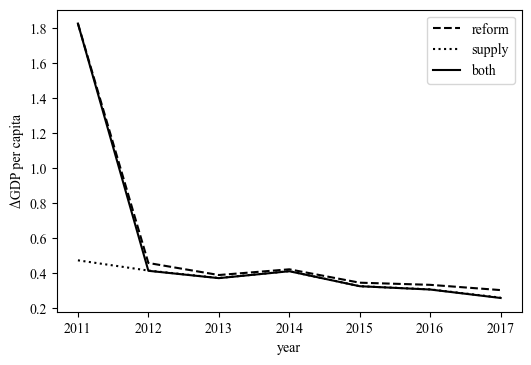

In [ ]:
fig, ax = plt.subplots(dpi=100)
ax.plot(pd.Series(range(2011, 2018, 1)), dW_country_compare.reform, 'k--', label='reform')
ax.plot(pd.Series(range(2011, 2018, 1)), dW_country_compare.supply, 'k:', label='supply')
ax.plot(pd.Series(range(2011, 2018, 1)), dW_country_compare.both, 'k-', label='both')

ax.set_xlabel('year', fontproperties=english_font)
ax.set_ylabel('ΔGDP per capita', fontproperties=english_font)

for tick in ax.get_yticklabels() + ax.get_yticklabels() + ax.get_xticklabels() + ax.get_xticklabels():
    tick.set_fontproperties(english_font)

plt.legend(prop=english_font)
plt.show()

In [ ]:
# 对比三种情形下的居民福利

V_prime_country_compare = pd.concat([
    1 + pd.Series([0] + dV_country_reform) / 100, 
    1 + pd.Series([0] + dV_country_supply) / 100, 
    1 + pd.Series([0] + dV_country_both) / 100
    ], axis=1
)

V_prime_in_compare = pd.concat([
    1 + pd.Series([0] + dV_in_reform) / 100, 
    1 + pd.Series([0] + dV_in_supply) / 100, 
    1 + pd.Series([0] + dV_in_both) / 100
    ], axis=1
)

V_prime_out_compare = pd.concat([
    1 + pd.Series([0] + dV_out_reform) / 100, 
    1 + pd.Series([0] + dV_out_supply) / 100, 
    1 + pd.Series([0] + dV_out_both) / 100
    ], axis=1
)

dV_country_compare = (np.array(V_prime_country_compare)[1:, :] / np.array(V_prime_country_compare)[:-1, :] - 1) * 100
dV_country_compare = pd.concat([pd.Series(range(2011, 2018, 1)), pd.DataFrame(dV_country_compare)], axis=1)
dV_country_compare.columns = ['year', 'reform', 'supply', 'both']
dV_in_compare = (np.array(V_prime_in_compare)[1:, :] / np.array(V_prime_in_compare)[:-1, :] - 1) * 100
dV_in_compare = pd.concat([pd.Series(range(2011, 2018, 1)), pd.DataFrame(dV_in_compare)], axis=1)
dV_in_compare.columns = ['year', 'reform', 'supply', 'both']
dV_out_compare = (np.array(V_prime_out_compare)[1:, :] / np.array(V_prime_out_compare)[:-1, :] - 1) * 100
dV_out_compare = pd.concat([pd.Series(range(2011, 2018, 1)), pd.DataFrame(dV_out_compare)], axis=1)
dV_out_compare.columns = ['year', 'reform', 'supply', 'both']

dV_country_compare

,year,reform,supply,both
0,2011,3.192902,0.504834,3.191393
1,2012,0.488242,0.464264,0.460886
2,2013,0.414592,0.402996,0.401402
3,2014,0.449584,0.452721,0.449906
4,2015,0.367690,0.356436,0.354020
5,2016,0.354597,0.342128,0.339214
6,2017,0.322375,0.298556,0.294386


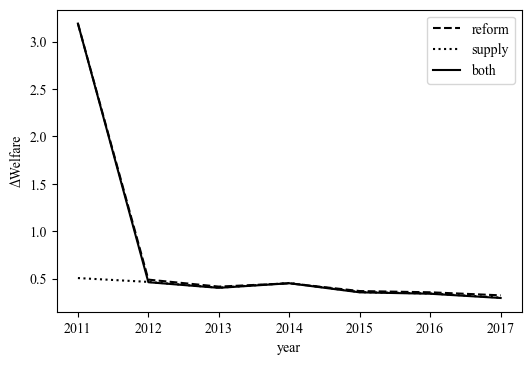

In [ ]:
fig, ax = plt.subplots(dpi=100)
ax.plot(pd.Series(range(2011, 2018, 1)), dV_country_compare.reform, 'k--', label='reform')
ax.plot(pd.Series(range(2011, 2018, 1)), dV_country_compare.supply, 'k:', label='supply')
ax.plot(pd.Series(range(2011, 2018, 1)), dV_country_compare.both, 'k-', label='both')

ax.set_xlabel('year', fontproperties=english_font)
ax.set_ylabel('ΔWelfare', fontproperties=english_font)

for tick in ax.get_yticklabels() + ax.get_yticklabels() + ax.get_xticklabels() + ax.get_xticklabels():
    tick.set_fontproperties(english_font)

plt.legend(prop=english_font)
plt.show()

In [ ]:
# 对比三种情形下的省际人均GDP基尼系数

incgini_country_compare = pd.concat([
    pd.Series([incgini_country2010] + gini_index_country_reform), 
    pd.Series([incgini_country2010] + gini_index_country_supply), 
    pd.Series([incgini_country2010] + gini_index_country_both)
    ], axis=1
)

dincgini_country_compare = (np.array(incgini_country_compare)[1:, :] / np.array(incgini_country_compare)[:-1, :] - 1) * 100
dincgini_country_compare = pd.concat([pd.Series(range(2011, 2018, 1)), pd.DataFrame(dincgini_country_compare)], axis=1)
dincgini_country_compare.columns = ['year', 'reform', 'supply', 'both']

dincgini_country_compare

,year,reform,supply,both
0,2011,-1.968829,-0.086037,-2.052050
1,2012,-0.008153,-0.158573,-0.168324
2,2013,-0.006917,-0.173565,-0.189739
3,2014,-0.007491,-0.076951,-0.084698
4,2015,-0.006123,-0.139615,-0.152572
5,2016,-0.005900,-0.144080,-0.148875
6,2017,-0.005360,-0.154142,-0.158152


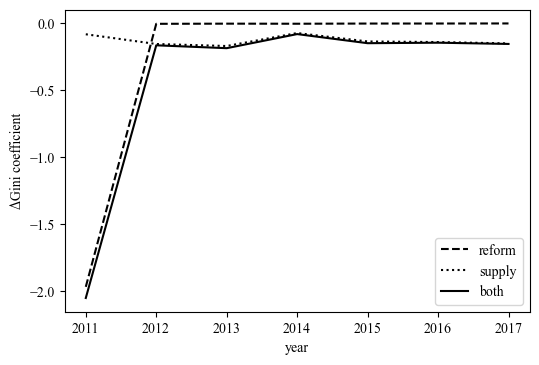

In [ ]:
fig, ax = plt.subplots(dpi=100)
ax.plot(pd.Series(range(2011, 2018, 1)), dincgini_country_compare.reform, 'k--', label='reform')
ax.plot(pd.Series(range(2011, 2018, 1)), dincgini_country_compare.supply, 'k:', label='supply')
ax.plot(pd.Series(range(2011, 2018, 1)), dincgini_country_compare.both, 'k-', label='both')

ax.set_xlabel('year', fontproperties=english_font)
ax.set_ylabel('ΔGini coefficient', fontproperties=english_font)

for tick in ax.get_yticklabels() + ax.get_yticklabels() + ax.get_xticklabels() + ax.get_xticklabels():
    tick.set_fontproperties(english_font)

plt.legend(prop=english_font)
plt.show()

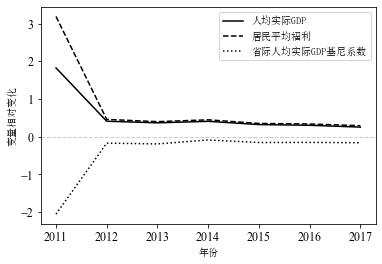

In [ ]:
## 历年变化
fig, ax = plt.subplots()
ax.plot(pd.Series(range(2011, 2018, 1)), dW_country_compare.both, 'k-', label='人均实际GDP')
ax.plot(pd.Series(range(2011, 2018, 1)), dV_country_compare.both, 'k--', label='居民平均福利')
ax.plot(pd.Series(range(2011, 2018, 1)), dincgini_country_compare.both, 'k:', label='省际人均实际GDP基尼系数')
ax.set_xlabel('年份', fontproperties=chinese_font)
ax.set_ylabel('变量相对变化', fontproperties=chinese_font)
ax.axhline(0, color='0.8', ls='--', lw=1)

for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontproperties(english_font)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.legend(prop=chinese_font)
plt.show()